(non_linear_coupling)=
# Continuous_HGF: non-linear value coupling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ilabcode/pyhgf/blob/master/docs/source/notebooks/1.4-Continuous_HGF_non_linear_value_coupling.ipynb)

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    !pip install pyhgf watermark

In [2]:
# imports
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax import jit, lax
from pyhgf.model import Network

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


When using value coupling in previous examples, the coupling function $g$ between nodes was assumed to be linear (identity, or in a form like $g_{b,a}(x) = Ax + B$). 
Since both the belief update step and the prediction error step use first and second order derivatives of the coupling function $g'$ and $g''$, in the case of a linear coupling the equations can be simplified, as $x$ disappears during the derivation process.

However, this is not the case for non-linear functions, in which $g'$ and $g''$ can still contain complex expressions involving $x$. 

In the PyHGF package, the default equations if coupling functions between nodes are not specified are the simplified ones (in which the coupling function is assumed to be the identity function), but it is possible to manually input non-linear functions in the parent node when building the network. We will illustrate how to do it and provide a simple example in which changing the coupling function can be relevant.

## RELU activation function

For this tutorial we will try to fit a 2-level continuous HGF to some data that are expected to behave in a known non-linear way. 

Let's imagine a signal that behaves differently when above and below a certain threshold $a$.

Specifically, we can create a signal $u_2$ consisting in a gaussian random walk with some drift.

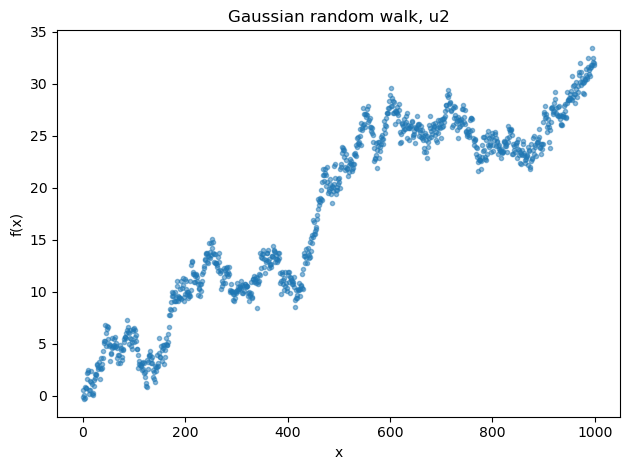

In [3]:
np.random.seed(43)

# create u2 as a gaussian random walk
random_walk = np.cumsum(np.random.normal(0.03, 0.5, 1000))

low_noise = 0.5
u2 = random_walk + np.random.normal(0.01, low_noise, 1000)

# plot the signal
plt.plot(u2, marker=".", alpha=0.5, linestyle="")
plt.title("Gaussian random walk, u2")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tight_layout()
plt.show()

Imagine that this behaviour constitutes a signal of a given underlying phenomenon. Now, we want to measure the same phenomenon with another instrument that above the same threshold $a$ is able to track the signal $u_2$, but below that threshold just gives us some noise. 
This measurement is supposed to be also noisier than the underlying signal.

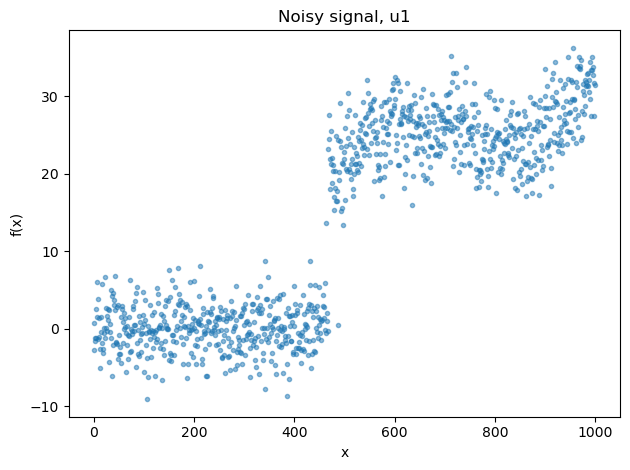

In [4]:
np.random.seed(43)
high_noise = 3
a = 19  # setting an arbitrary threshold

u1 = np.zeros(len(u2))
for i in range(len(u2)):
    if u2[i] > a:
        u1[i] = u2[i]
    else:
        u1[i] = 0
u1 = u1 + (np.random.normal(0, high_noise, 1000))

# plot the signal
plt.plot(u1, marker=".", alpha=0.5, linestyle="")
plt.title("Noisy signal, u1")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tight_layout()
plt.show()

Plotting them together we can see how $u_2$ and $u_1$ behaviours are different below the threshold, but similar above.

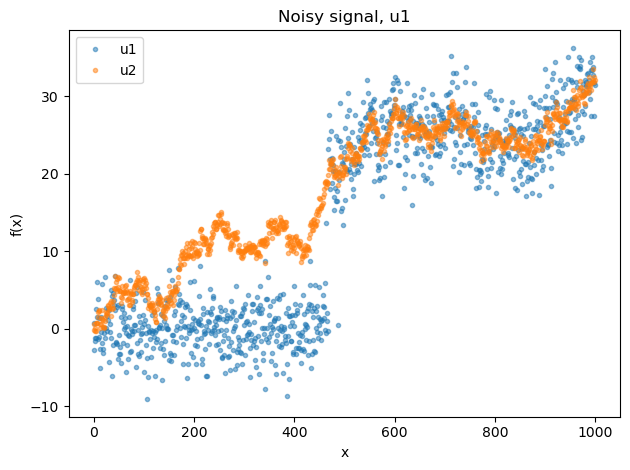

In [5]:
plt.plot(u1, marker=".", alpha=0.5, linestyle="", label="u1")
plt.plot(u2, marker=".", alpha=0.5, linestyle="", label="u2")
plt.title("Noisy signal, u1")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.tight_layout()
plt.show()

If we know the underlying dynamic of the original signal ($u_2$), can we build an HGF network capable of using this information to predict the behaviour of the measured signal ($u_1$)?

Yes, through non-linear coupling! 

Imagine a network in which a value parent node $x_2$ receives information both from a continuous input node registering $u_2$ and a child node $x_1$ connected to another continuous input node registering $u_1$. We already know how to create a custom network assuming linear coupling.

$$
x_2^{(k)} \sim Normal(\lambda_2x_2^{(k-1)}, \theta_2)\\
x_1^{(k)} \sim Normal(f_{2,1}(x_2^{(k)})), \theta_1)
$$

where $\lambda$ is the autoconnection strength and $\theta$ the tonic volatility of each node. Note that the autoconnection strength of $x_1$ is set to 0, so that the node mean is informed just by $f_{2,1}(x_2^{(k)})$, being $f_{2,1}$ the coupling function between $x_2$ and $x_1$. This allows us to couple the two nodes without $x_1^{(k)}$ being influenced by its previous state.

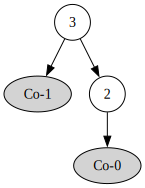

In [6]:
linear_hgf = (
    Network()
    .add_nodes(
        kind="continuous-input", input_precision=1 / high_noise**2
    )  # u1 - Continuous node 0
    .add_nodes(
        kind="continuous-input", input_precision=1 / (low_noise) ** 2
    )  # u2 - Continuous node 1
    .add_nodes(value_children=0, n_nodes=1, autoconnection_strength=0)  # x1 - node 2
    .add_nodes(
        value_children=[1, 2],
        n_nodes=1,
    )  # x2 - node 3
)
linear_hgf.plot_network()

In order to implement the non-linear coupling, we need to specify a coupling function. In this case, we need a function that allows $x_1$ to predict that the input signal below a threshold will be just random noise, but above the threshold is equal to the behaviour displayed by $u_2$.

We can therefore shape the function as follows:

\begin{cases} 
\ u_2 & \text{for } x > a \\
 0 & \text{for } x \leq a 
\end{cases}

For now, we are fixing the parameters knowing how the signal is generated.


In [7]:
# Creating the functions
def identity(x):
    return x


def f(x, a=19):
    return lax.cond(
        x > a, lambda x: x, lambda x: 0.0, x  # Case for x > a  # Case for x <= a
    )

It is then possible to input the function into the parent node, using the argument `coupling_funct`, that accepts Tuples. If the value parent, as in this case, possesses multiple children, all the functions must be inputed in the same order the value children are declared in the `value_children` argument.

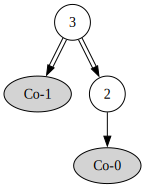

In [8]:
nonlinear_hgf = (
    Network()
    .add_nodes(
        kind="continuous-input", input_precision=1 / high_noise**2
    )  # u1 - Continuous node 0
    .add_nodes(
        kind="continuous-input", input_precision=1 / (low_noise) ** 2
    )  # u2 - Continuous node 1
    .add_nodes(value_children=0, n_nodes=1, autoconnection_strength=0)  # x1 - node 2
    .add_nodes(
        value_children=[1, 2], n_nodes=1, coupling_fn=(identity, f)
    )  # x2 - node 3 - coupling functions expressed
)
nonlinear_hgf.plot_network()

Let's see how our two networks perform when we input the data.

In [9]:
# data input
input_data = input_data = np.array([u1, u2]).T

linear_hgf = linear_hgf.input_data(input_data=input_data)
nonlinear_hgf = nonlinear_hgf.input_data(input_data=input_data)

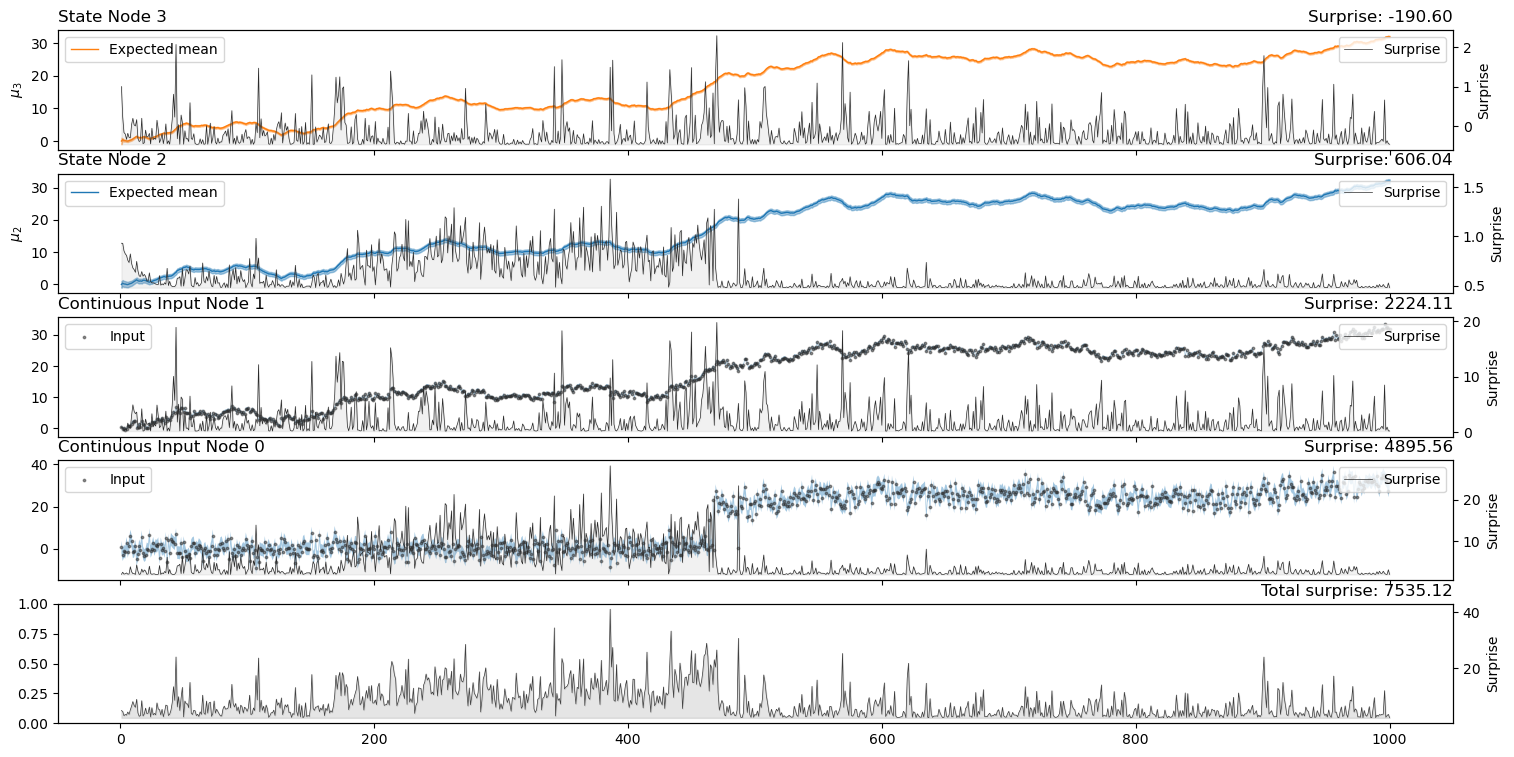

In [10]:
# plot traces
linear_hgf.plot_trajectories();

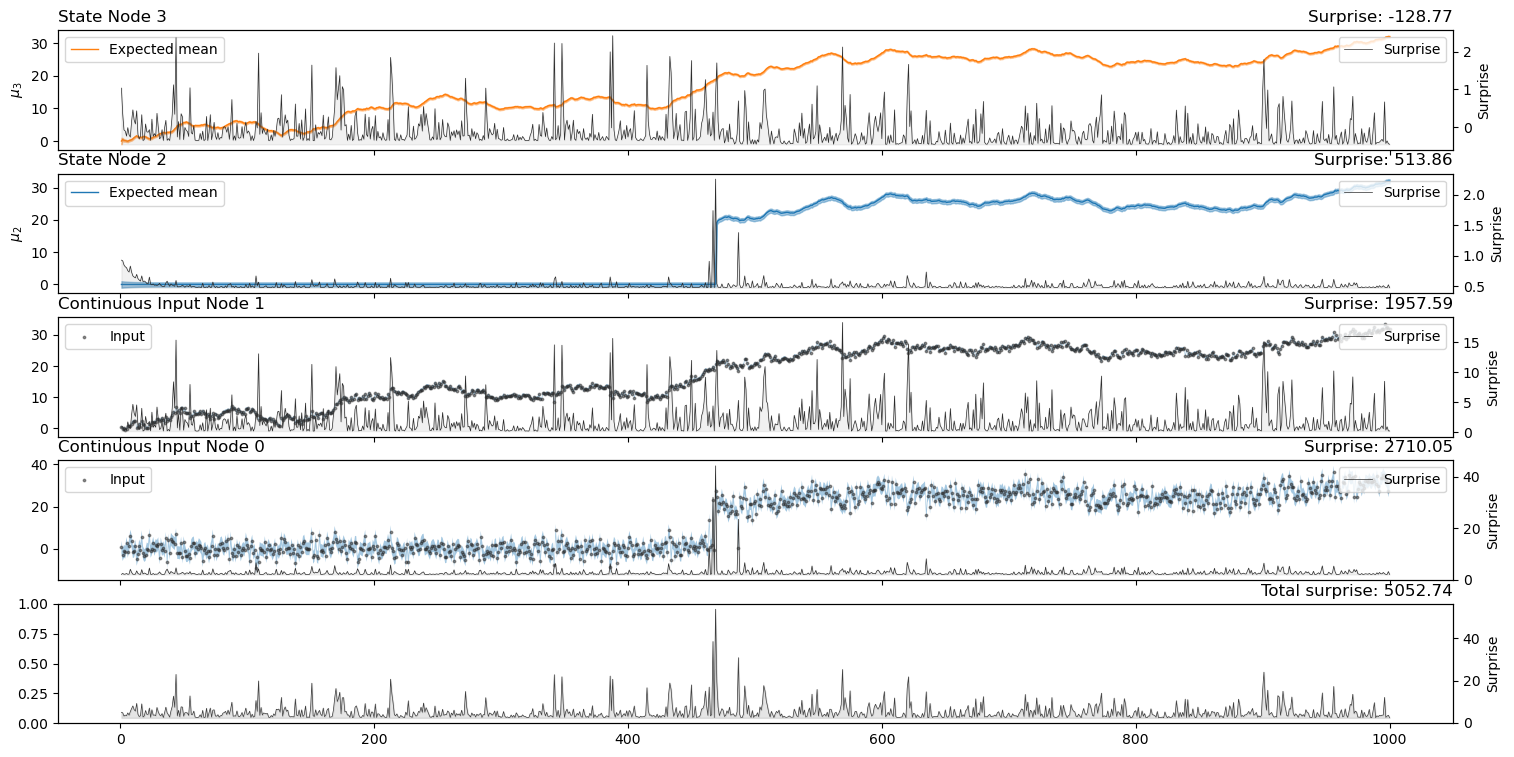

In [11]:
nonlinear_hgf.plot_trajectories();

Let's have a closer look at the behaviour of $x_1$ ("State node 2" in the plot)

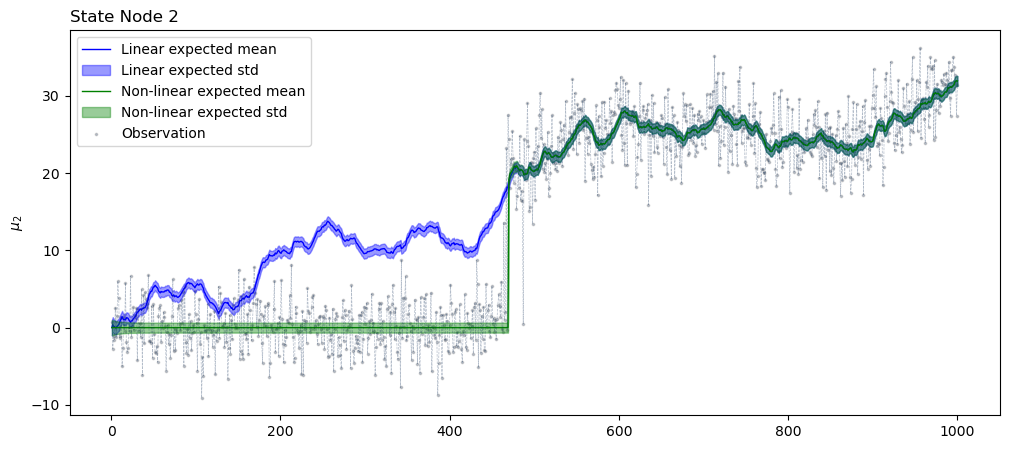

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

linear_hgf.plot_nodes(2, axs=ax, color="blue", show_surprise=False)
nonlinear_hgf.plot_nodes(
    2, axs=ax, color="green", show_surprise=False, show_observations=True
)

ax.legend(
    [
        "Linear expected mean",
        "Linear expected std",
        "Non-linear expected mean",
        "Non-linear expected std",
        "Observation",
    ]
)

Notice how the HGF manages to track the gaussian random walk even with the linear coupling. However, it is using data coming from $u_2$ to inform $x_1$ state through the value parent $x_2$ even below the threshold, something that in this specific example is incorrect, as $u_1$ behaviour is non-linear and depends on a threshold. Providing a coupling function allows us to use the information coming from $u_2$ just when needed, allowing a more precise tracking.

# Sinusoidal functions

For simple non linear behaviour though, the linear HGF is good enough to track the signal.

Let's consider for example an oscillatory behaviour.

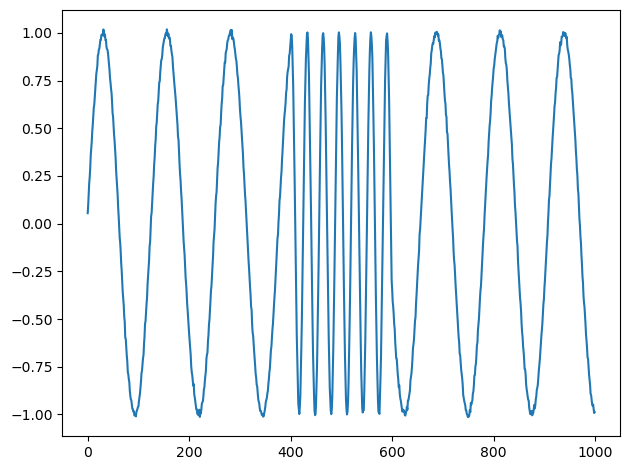

In [13]:
np.random.seed(42)
x = np.ones(1000)
x[400:600] = 4
x = np.cumsum(x)
std = 0.01

input_data = np.sin(x/20) + np.random.normal(0,std,1000) # sinusoid + noise

observed = np.ones(1000)
observed[700:900] = 0

plt.plot(input_data)
plt.tight_layout()
plt.show()

In [14]:
nonlinear_hgf = (
    Network()
    .add_nodes(kind="continuous-input", 
               input_precision=1/std**2) # u1 - Continuous node 0
    .add_nodes(value_children=0, autoconnection_strength=0) # x1 - node 1
    .add_nodes(
        value_children=1, 
        mean=10.0,
        autoconnection_strength=1,
        coupling_fn=(jnp.sin,)
              ) # x1 - node 1
    .add_nodes(value_children=2,
               mean=1,
               precision=10,
               ) # x2 - node 2 - coupling functions expressed
)

In [15]:
nonlinear_hgf.edges

(AdjacencyLists(node_type=0, value_parents=(1,), volatility_parents=None, value_children=None, volatility_children=None, coupling_fn=(None, None)),
 AdjacencyLists(node_type=2, value_parents=(2,), volatility_parents=None, value_children=(0,), volatility_children=None, coupling_fn=(None, None)),
 AdjacencyLists(node_type=2, value_parents=(3,), volatility_parents=None, value_children=(1,), volatility_children=None, coupling_fn=(<PjitFunction of <function sin at 0x7f55c970a340>>, <PjitFunction of <function sin at 0x7f55c970a340>>)),
 AdjacencyLists(node_type=2, value_parents=None, volatility_parents=None, value_children=(2,), volatility_children=None, coupling_fn=(None, None)))

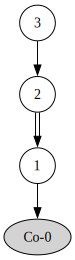

In [16]:
nonlinear_hgf.plot_network()

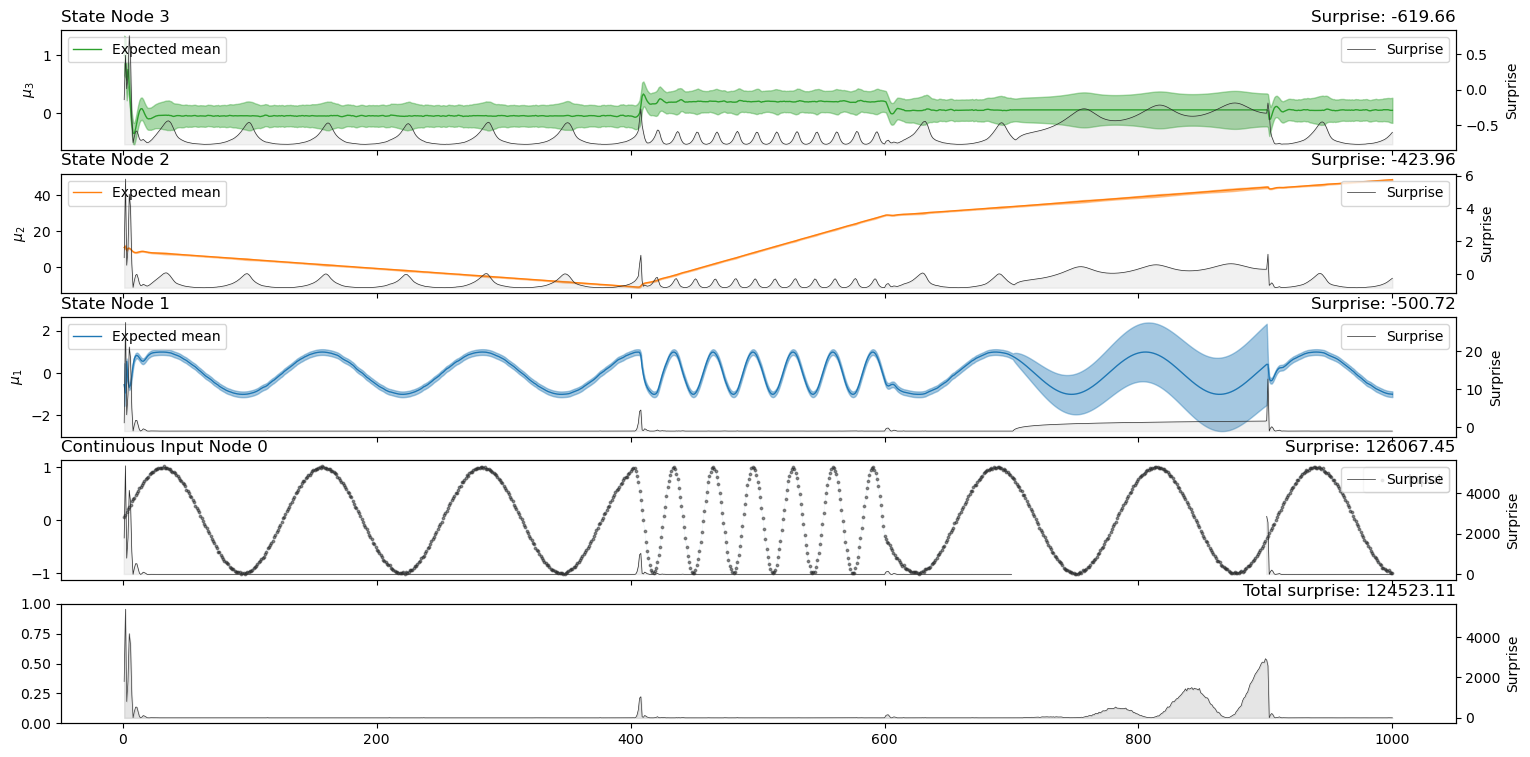

In [17]:
nonlinear_hgf = nonlinear_hgf.input_data(input_data, observed=observed)
nonlinear_hgf.plot_trajectories();

# System configuration

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pyhgf,jax,jaxlib

Last updated: Mon Aug 12 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.23.0

pyhgf : 0.1.2
jax   : 0.4.31
jaxlib: 0.4.31

matplotlib: 3.8.4
numpy     : 1.26.0
sys       : 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
jax       : 0.4.31

Watermark: 2.4.3

